# Project: What factors influence a patient to show up for their scheduled appointment?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#dw">Data Wrangling</a></li>
<li><a href="#clean">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
# Introduction

>This dataset collects information from medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. As we start investigating we will try to answer the question about What are the factors and attributes to predict if a patient will show up for their scheduled appointment.

### Importing Libraries

In [281]:
import pandas as pd
import numpy as np
#import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, timezone
import math
%matplotlib inline

### Creating functions that will help in the data investigation

In [282]:
def hist_comp_prop(group: str,df1,df2, title:str):
    # Compares all the numeric columns of two dataframes and plot a proportional and overlapped histogram
    
    
    try:
        df1.columns.all() == df2.columns.all()
    except:
        print("Dataframes must have the same column names and positions. Prepare data before use this function")
    
    df_full = pd.concat([df1,df2])
    fig = plt.figure(figsize = [20,20])
    elem = sorted(set(df_full[group]))
    a = 1
    alpha = {}
    for e in elem:
        alpha[e] = a
        a = a/2
    
    #Selecting only the numeric columns 
    col = df1.select_dtypes(include=np.number).columns
    
    #Identifying the matrix plot size
    c = len(col)
    root = math.sqrt(c)
    check_size = False
    while check_size == False:
        if int(root+0.5)**2 == c:
            check_size = True
            s = math.sqrt(c)
        else:
            c += 1
            root = math.sqrt(c)
    matrix_fig = [int(s),int(s)]
    
    for ind, column in enumerate(col):
        #Creating the bins based on the combination of both df
        bins = np.linspace(df_full[column].min(), df_full[column].max(), 10)
        
        plt.subplot(matrix_fig[0], matrix_fig[1], ind+1)
        subNum = 0
        for ind, grp in df_full.groupby(group):
            grp[column].hist(bins=bins, density = True, label = ind, alpha = alpha[list(alpha)[subNum]])
            subNum +=1
        plt.title(column)
        plt.legend()
    fig.suptitle(title, fontsize=30)
    
def class_plot (df1, df2,label1, label2,column):
    # Compares one class column of two dataframes bringing a bar chart of each df 
    try:
        df1.columns.all() == df2.columns.all()
    except:
        print("Dataframes must have the same column names and positions. Prepare data before use this function")
    fig = plt.figure(figsize = [10,5])
    # Merging both df to collect the total number by group
    df_full = pd.concat([df1,df2])
    df_full_grouped = df_full[column].value_counts().sort_index()
    bins = df_full_grouped.index.tolist()
    # Grouping the df by the desired field
    h1 = (df1[column].value_counts().sort_index())
    h2 = (df2[column].value_counts().sort_index())
    # Calculate the proportions to level up the df
    h1_prop = np.true_divide(h1, df_full_grouped)
    h2_prop = np.true_divide(h2, df_full_grouped)
    cap = max(np.append(h1_prop, h2_prop))*1.1
    fig_title = f"Comparison of {column} for {label1} and {label2} Groups"
    
    plt.subplot(1, 2, 1)
    plt.ylim(0,cap)
    h1_prop.plot(kind='bar', title = label1)
    plt.subplot(1, 2, 2)
    plt.ylim(0,cap)
    h2_prop.plot(kind='bar', title = label2)
    fig.suptitle(fig_title, fontsize=30, y = 1.1)

<a id='dw'></a>
# Data Wrangling

In [283]:
# Loading Data
df_noshow = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")
df_noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [284]:
# Checking whether the columns meet the datatype
df_noshow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


>We see that the columns "ScheduledDay" and "AppointmentDay" need to be converted into a date and time type, also, there are  typo error in the columns "Handcap" and "Hipertension" and the column "No-show", the way it is can not be properly used with some pandas functions. 
Therefore, let's fix these problems and lower case all the columns to standardize the dataframe.

#### Fixing typos and lowering case the column names

In [285]:
df_noshow.rename(columns = {"PatientId": "patient_id", "AppointmentID": "appointment_id", "AppointmentDay": "appointment_day","Handcap": "handicap", "No-show": "no_show", "Hipertension": "hypertension", "ScheduledDay": "scheduled_day"}, inplace = True)

In [286]:
df_noshow.columns = df_noshow.columns.str.lower()
df_noshow.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Changing columns data type into a more suitable one

In [287]:
df_noshow["scheduled_day"] = pd.to_datetime(df_noshow["scheduled_day"]).dt.tz_localize(None)
df_noshow["appointment_day"] = pd.to_datetime(df_noshow["appointment_day"]).dt.tz_localize(None)
df_noshow["patient_id"] = df_noshow['patient_id'].astype('int64')

In [288]:
# Truncating the scheduled_day field to fetch the number of days between appointment and scheduled dates. (this field can be very helpful)
df_noshow["scheduled_date"] = df_noshow["scheduled_day"].dt.date
df_noshow["scheduled_date"] = pd.to_datetime(df_noshow["scheduled_date"]).dt.tz_localize(None)
df_noshow["days_to_appointment"] = (df_noshow['appointment_day'] - df_noshow['scheduled_date']).dt.days
df_noshow.drop(columns = ["scheduled_date"], inplace = True) 
df_noshow.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   patient_id           110527 non-null  int64         
 1   appointment_id       110527 non-null  int64         
 2   gender               110527 non-null  object        
 3   scheduled_day        110527 non-null  datetime64[ns]
 4   appointment_day      110527 non-null  datetime64[ns]
 5   age                  110527 non-null  int64         
 6   neighbourhood        110527 non-null  object        
 7   scholarship          110527 non-null  int64         
 8   hypertension         110527 non-null  int64         
 9   diabetes             110527 non-null  int64         
 10  alcoholism           110527 non-null  int64         
 11  handicap             110527 non-null  int64         
 12  sms_received         110527 non-null  int64         
 13  no_show       

In [289]:
# Checking the amount of unique values we have in each column
df_noshow.nunique() 

patient_id              62299
appointment_id         110527
gender                      2
scheduled_day          103549
appointment_day            27
age                       104
neighbourhood              81
scholarship                 2
hypertension                2
diabetes                    2
alcoholism                  2
handicap                    5
sms_received                2
no_show                     2
days_to_appointment       131
dtype: int64

>Here is an interesting thing: There are 5 classes of handicap. Since there is no reference to the meaning of each reference, let's turn this column into a boolean value, like gender or scholarship.

In [290]:
df_noshow['handicap'] = df_noshow['handicap'].apply(lambda x: 1 if x!= 0 else x)
df_noshow.handicap.unique() 

array([0, 1], dtype=int64)

In [291]:
df_noshow.query("days_to_appointment < 0").head(20)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,days_to_appointment
27033,7839272661752,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-1
55226,7896293967868,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-1
64175,24252258389979,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-1
71533,998231581612122,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-6
72362,3787481966821,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-1


>Here is not necessarily a conclusion, but a remark that appointments made to a past day have 100% of no show. 
Despite this be impossible to return in time, it is not possible to confirm whether this was a mistake or it was intentionally input into the dataset. In order to preserve the quality of the data to further analysis, these records will be dropped from the dataset.

### Creating new columns to help in the further analysis

In [292]:
df_noshow['scheduled_weekday'] = df_noshow['scheduled_day'].dt.day_name() # column to get the day of the week   
df_noshow['appointment_weekday'] = df_noshow['appointment_day'].dt.day_name() #  column to get the day of the week 

In [293]:
df_noshow.tail()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,days_to_appointment,scheduled_weekday,appointment_weekday
110522,2572134369293,5651768,F,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No,35,Tuesday,Tuesday
110523,3596266328735,5650093,F,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No,35,Tuesday,Tuesday
110524,15576631729893,5630692,F,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No,41,Wednesday,Tuesday
110525,92134931435557,5630323,F,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No,41,Wednesday,Tuesday
110526,377511518121127,5629448,F,2016-04-27 13:30:56,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,No,41,Wednesday,Tuesday


In [294]:
# Checking duplicated values
sum(df_noshow.duplicated())

0

#### Checking the dataset content

In [295]:
# Let's start checking the content of the classes columns
class_cols = df_noshow.select_dtypes(exclude = [np.number, np.datetime64]).columns

for i, j in enumerate(class_cols):
    l = len(df_noshow[j].unique())
    print(f"{j} ==>", df_noshow[j].unique(), f"size ==> {l}" ,"\n")


gender ==> ['F' 'M'] size ==> 2 

neighbourhood ==> ['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO'
 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA'
 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO'
 'BOA VISTA' 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH'
 'SANTA TEREZA

>Nothing strange so far. As expected, only two values for "gender" and "no_show". We know in advance that the healthcare facilities don't work on sundays.

In [296]:
#Checking for duplicated
df_noshow.duplicated().sum()

0

No duplicated values. We can skip this cleaning process.

In [297]:
# Checking for null values
df_noshow.isna().any()

patient_id             False
appointment_id         False
gender                 False
scheduled_day          False
appointment_day        False
age                    False
neighbourhood          False
scholarship            False
hypertension           False
diabetes               False
alcoholism             False
handicap               False
sms_received           False
no_show                False
days_to_appointment    False
scheduled_weekday      False
appointment_weekday    False
dtype: bool

>Also a good quality sign. Moving on

In [298]:
# Let's guarantee that the date columns are not bringing impossible dates, like in the past century or in a far away future

date_cols = df_noshow.select_dtypes(include = [np.datetime64]).columns

for i, j in enumerate(date_cols):
    ma = max(df_noshow[j])
    mi = min(df_noshow[j])
    un = df_noshow[j].nunique()
    print(f"{j} ==>", f"Min Date: {mi}, ", f"Max Date: {ma}, ", f"Distinct dates: {un}" ,"\n")



scheduled_day ==> Min Date: 2015-11-10 07:13:56,  Max Date: 2016-06-08 20:07:23,  Distinct dates: 103549 

appointment_day ==> Min Date: 2016-04-29 00:00:00,  Max Date: 2016-06-08 00:00:00,  Distinct dates: 27 



>No impossible dates.

In [299]:
# Checking the numeric values
df_noshow.describe()

,patient_id,appointment_id,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_to_appointment
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.020276,0.321026,10.183702
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.140942,0.466873,15.254996
min,3.921700e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000


>We see that there is an impossible age. This will be corrected in the next step

<a id='clean'></a>
# Data Cleaning

In [300]:
# Discarding Negative values for age
df_noshow_clnd = df_noshow.loc[df_noshow['age']>= 0].copy()
# Removing the appointment in the past
df_noshow_clnd = df_noshow_clnd.query("days_to_appointment >= 0")
df_noshow_clnd.reset_index(drop = True, inplace = True)
df_noshow_clnd.describe()

,patient_id,appointment_id,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_to_appointment
count,1.105210e+05,1.105210e+05,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000,110521.000000
mean,1.474906e+14,5.675304e+06,37.089386,0.098271,0.197257,0.071869,0.030401,0.020259,0.321043,10.184345
std,2.560860e+14,7.129691e+04,23.109885,0.297682,0.397929,0.258272,0.171690,0.140884,0.466879,15.255153
min,3.921700e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172457e+12,5.640284e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173185e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,9.438963e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000


##### Let's create a group of ages. This field will be useful in the sequence

In [301]:
ages = df_noshow_clnd.age.unique()
ages = np.positive(ages)
ages = ages[ages>=0]
ages.sort()

In [302]:
age_labels = []
age_bins = []


# Checking the extremes
min_bin = min(ages)

while min_bin%10 !=0:
    min_bin -= 1

max_bin = max(ages)

while max_bin%10 != 0:
    max_bin+=1   
    
#Creating the bin list

for i in range(min_bin,max_bin+1,10):
    age_bins.append(i)
    
 

while min_bin < max(ages):
    
    if min_bin == 0:
        c = str(min_bin)+'-'+str(min_bin+10)
    else:
        c = str(min_bin+1)+'-'+str(min_bin+10)
    age_labels.append(c)
    min_bin +=10
print('labels ==> ', age_labels)
print('bins ==> ', age_bins)

labels ==>  ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '111-120']
bins ==>  [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]


In [303]:
df_noshow_clnd['agegroup'] = pd.cut(df_noshow_clnd['age'], age_bins, labels = age_labels)

In [304]:
df_noshow_clnd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   patient_id           110521 non-null  int64         
 1   appointment_id       110521 non-null  int64         
 2   gender               110521 non-null  object        
 3   scheduled_day        110521 non-null  datetime64[ns]
 4   appointment_day      110521 non-null  datetime64[ns]
 5   age                  110521 non-null  int64         
 6   neighbourhood        110521 non-null  object        
 7   scholarship          110521 non-null  int64         
 8   hypertension         110521 non-null  int64         
 9   diabetes             110521 non-null  int64         
 10  alcoholism           110521 non-null  int64         
 11  handicap             110521 non-null  int64         
 12  sms_received         110521 non-null  int64         
 13  no_show       

> It seems that some rows did not get an age group. Let's check which ages did not get an "agegroup"

In [305]:
df_miss_group = df_noshow_clnd.query("agegroup.isnull()")
df_miss_group.age.value_counts()

0    3539
Name: age, dtype: int64

Only the recors with age == 0 did not have a group assigned. Let's fill the gaps

In [306]:
df_noshow_clnd["agegroup"] = df_noshow_clnd["agegroup"].fillna("0-10")
df_noshow_clnd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   patient_id           110521 non-null  int64         
 1   appointment_id       110521 non-null  int64         
 2   gender               110521 non-null  object        
 3   scheduled_day        110521 non-null  datetime64[ns]
 4   appointment_day      110521 non-null  datetime64[ns]
 5   age                  110521 non-null  int64         
 6   neighbourhood        110521 non-null  object        
 7   scholarship          110521 non-null  int64         
 8   hypertension         110521 non-null  int64         
 9   diabetes             110521 non-null  int64         
 10  alcoholism           110521 non-null  int64         
 11  handicap             110521 non-null  int64         
 12  sms_received         110521 non-null  int64         
 13  no_show       

<a id='eda'></a>
# Exploratory Data Analysis

In [307]:
# Checking the proportion between the show and no show cases
no_show_proportion= df_noshow_clnd.query("no_show == 'Yes'").shape[0]/df_noshow_clnd.shape[0]
no_show_proportion

0.2018982817745044

> We are going to use the number above as a reference to what is relevant or not in the analysis. 

### Dividing the database in to compare

>Since no show status is the target of this study, let's first divide the database by this class and compare the results 

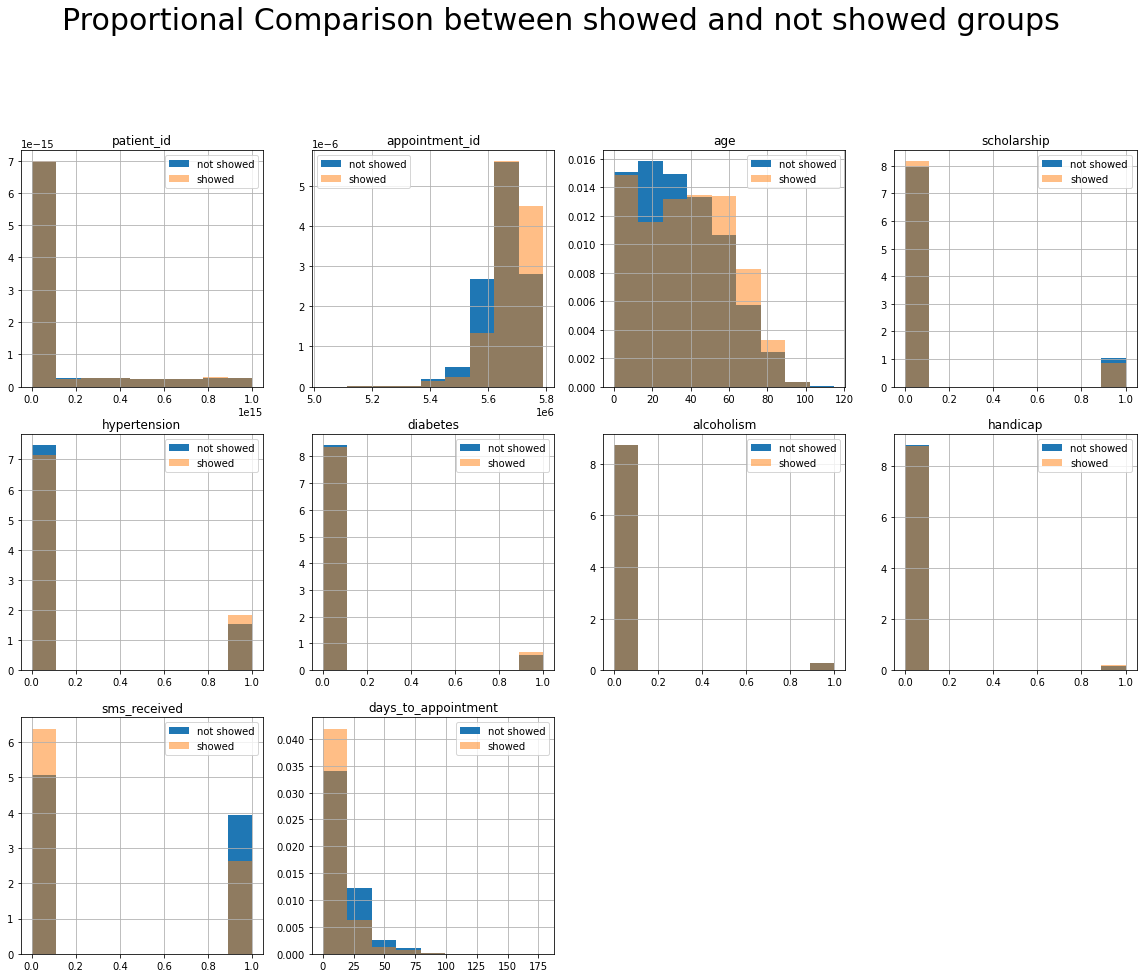

In [308]:
df_showed = df_noshow_clnd.query("no_show == 'No'").copy()
df_showed["no_show"].replace(('Yes', 'No'), ("not showed","showed"), inplace = True)
df_showed.reset_index(drop = True, inplace = True)
df_not_showed = df_noshow_clnd.query("no_show == 'Yes'").copy()
df_not_showed["no_show"].replace(('Yes', 'No'), ("not showed","showed"), inplace = True)
df_not_showed.reset_index(drop = True, inplace = True)

hist_title = "Proportional Comparison between showed and not showed groups"
hist_comp_prop(group = "no_show" ,df1 = df_showed,df2 = df_not_showed, title = hist_title)

>The distribution in this case is almost even for all the measures.
It's very hard to clearly find a measure that can define whether the patient will show or not.
However, it is possibible to notice some trends, for example the age:

>According to the histogram, despite all the groups share almost the same frequency, the group of age between 10-40 years is more willing to not show to the appointment. This makes sense if you consider that at this age people are in the workforce and would need to request a license to go to the appointment at the working hours.

>People with comorbidity like hypertension, slightly tend to show, if compared to those that don't have a pre-condition.

> Concerning the days before the appointment, people tend to not show when the appointment is above 20 days


###### Let's have a closer look in the age group

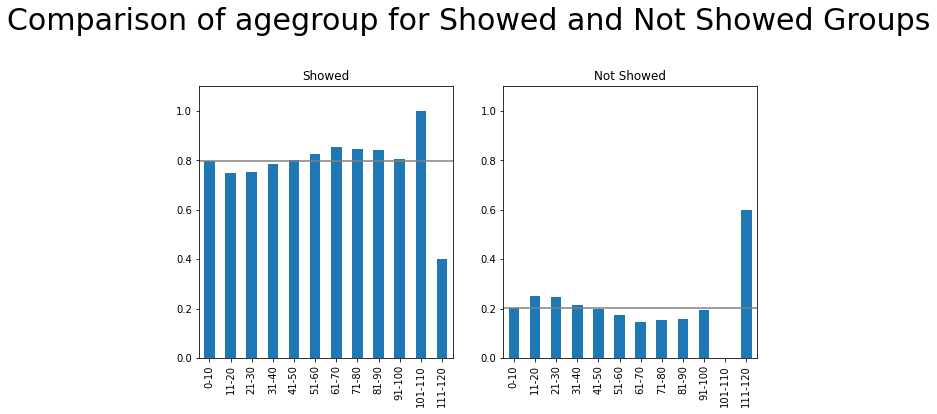

In [309]:
class_plot(df_showed, df_not_showed, 'Showed', 'Not Showed', 'agegroup')
# Adding the no_show proportion as reference bar to highlight the groups
plt.subplot(1, 2, 1)
plt.axhline(1-no_show_proportion, color = 'gray');
plt.subplot(1, 2, 2)
plt.axhline(no_show_proportion, color = 'gray');

> The chart above corroborates to the previous histogram, showing that people from 11-40 years old are more prone to not show to an appointment, considering the overall proportion as reference.
As the sample has very few data for the age group above 100 years old, it should be considered an outlier.

###### Let's have a closer look in the gender group

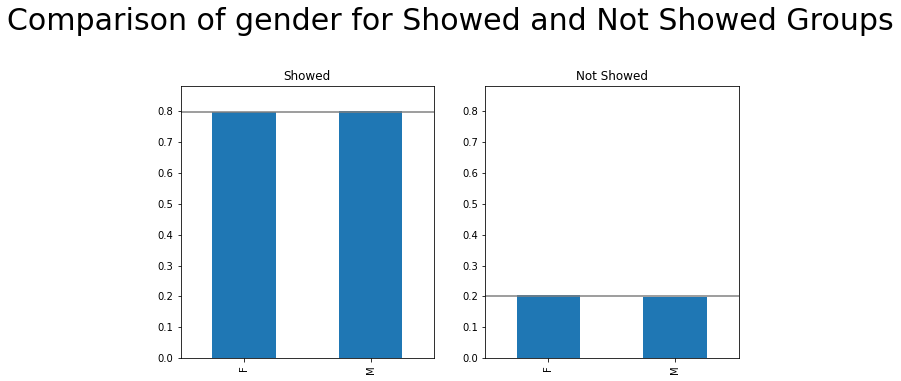

In [310]:
class_plot(df_showed, df_not_showed, 'Showed', 'Not Showed', 'gender')
plt.subplot(1, 2, 1)
plt.axhline(1-no_show_proportion, color = 'gray');
plt.subplot(1, 2, 2)
plt.axhline(no_show_proportion, color = 'gray');

> The gender is not a relevant feature in this case. The proportional amount of people for each group is almost even. 

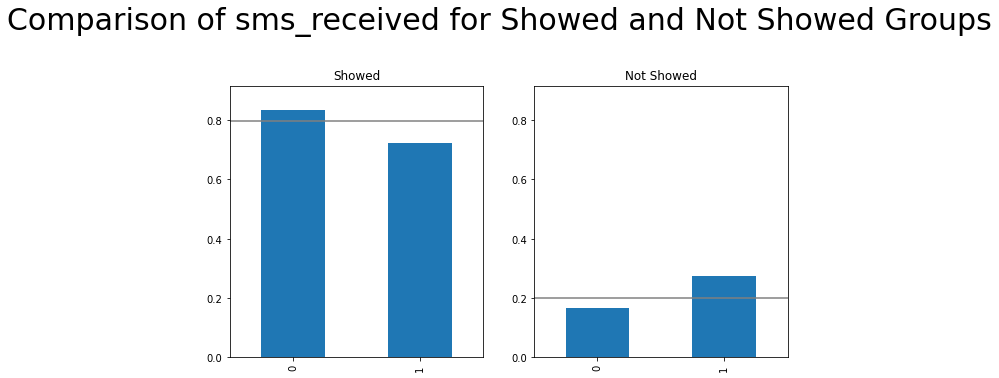

In [311]:
class_plot(df_showed, df_not_showed, 'Showed', 'Not Showed', 'sms_received')
plt.subplot(1, 2, 1)
plt.axhline(1-no_show_proportion, color = 'gray');
plt.subplot(1, 2, 2)
plt.axhline(no_show_proportion, color = 'gray');

> Here is an interesting case... It's not defined what the SMS is supposed to communicate, but I believe this is to reinforce the appointment date.
Curiously, the people that received the SMS are above the average of those that did not show to an appointment.
Something in the communication should be improved there.

##### Let's how comorbities influence the case


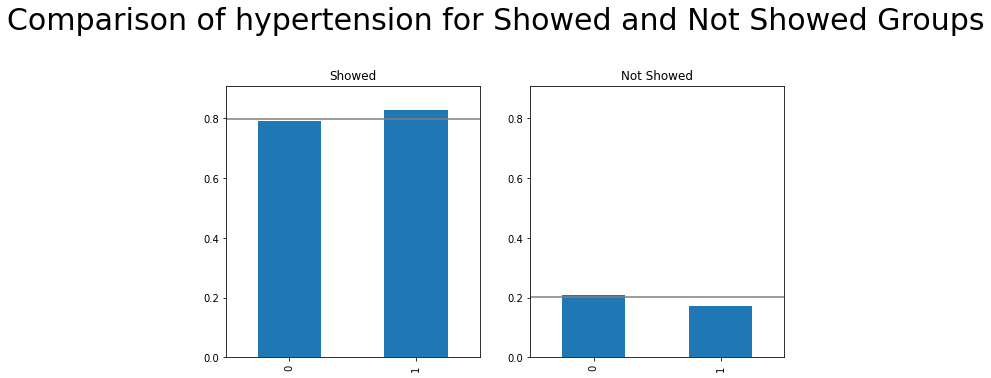

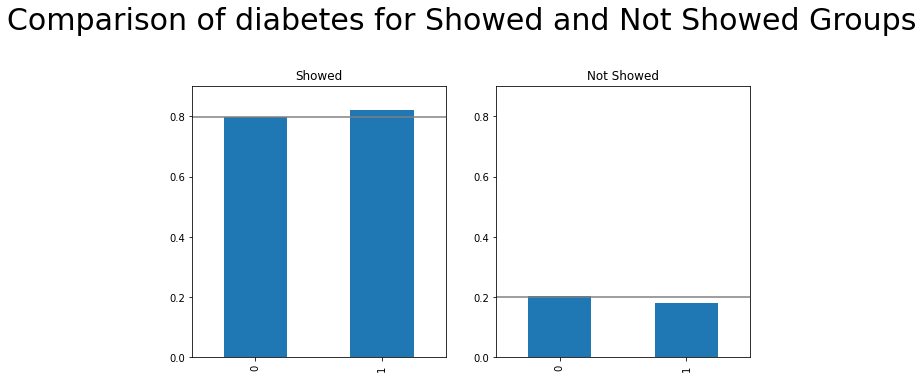

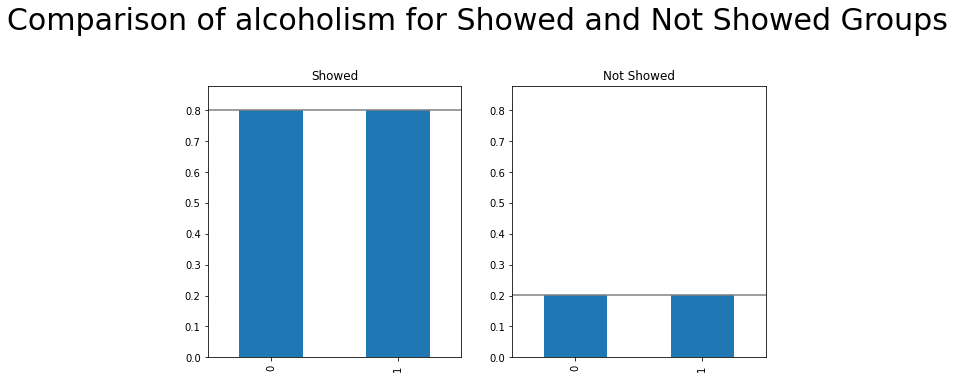

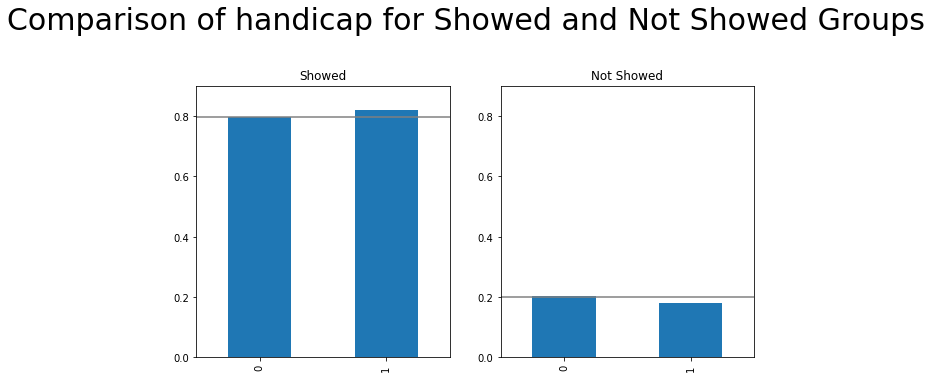

In [312]:
comorbities = ['hypertension', 'diabetes', 'alcoholism', 'handicap']

for i, j in enumerate(comorbities):
    class_plot(df_showed, df_not_showed, 'Showed', 'Not Showed', j)
    plt.subplot(1, 2, 1)
    plt.axhline(1-no_show_proportion, color = 'gray');
    plt.subplot(1, 2, 2)
    plt.axhline(no_show_proportion, color = 'gray');

> As seen in the histogram chart, the charts above show us that the people with one kind of comorbity has a higher show up rate compared to those that don't have. However this is not a relevant feature to predict whether a person will or not show.

##### Checking the appointment day of week

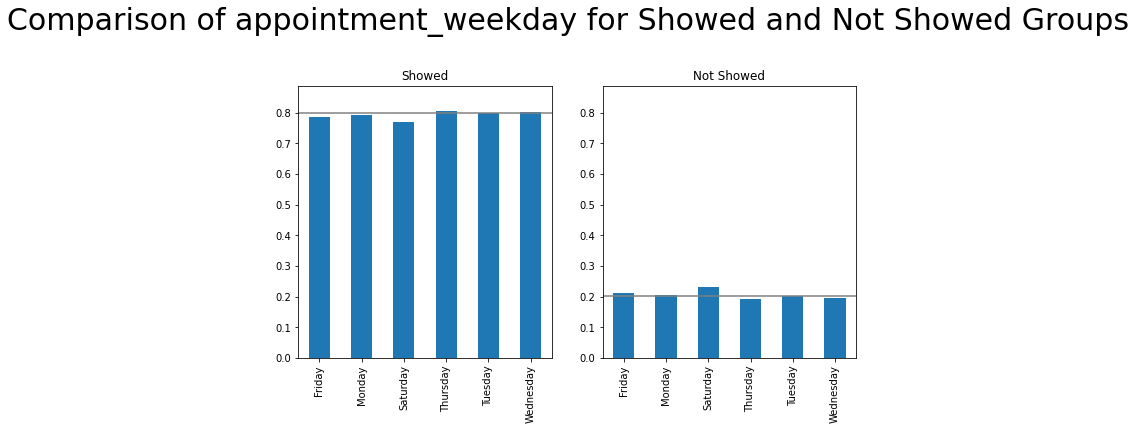

In [313]:
class_plot(df_showed, df_not_showed, 'Showed', 'Not Showed', 'appointment_weekday')
plt.subplot(1, 2, 1)
plt.axhline(1-no_show_proportion, color = 'gray');
plt.subplot(1, 2, 2)
plt.axhline(no_show_proportion, color = 'gray');

> The noshow rate is higher on Fridays and Saturdays. It can be a good feature and also justifies why so many healthcare services in Brazil do not work on weekends.

##### Since we had several appointments scheduled for the same date, let's check this feature

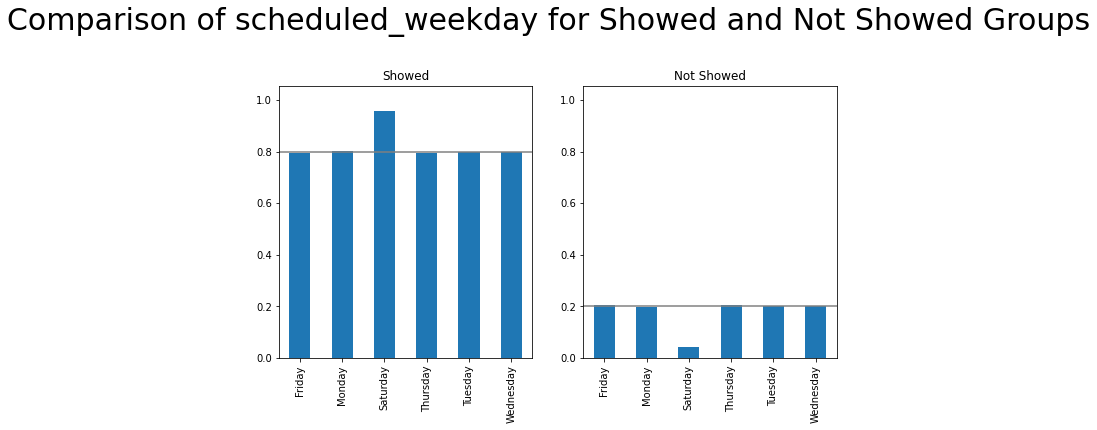

In [314]:
class_plot(df_showed, df_not_showed, 'Showed', 'Not Showed', 'scheduled_weekday')
plt.subplot(1, 2, 1)
plt.axhline(1-no_show_proportion, color = 'gray');
plt.subplot(1, 2, 2)
plt.axhline(no_show_proportion, color = 'gray');

> In practical terms, it should not have an influence the day someone scheduled, but, coincidence or not, if someone schedule an appointment on Saturday, there is a higher chance of this person showing up. 

##### Checking for the welfare enrollement

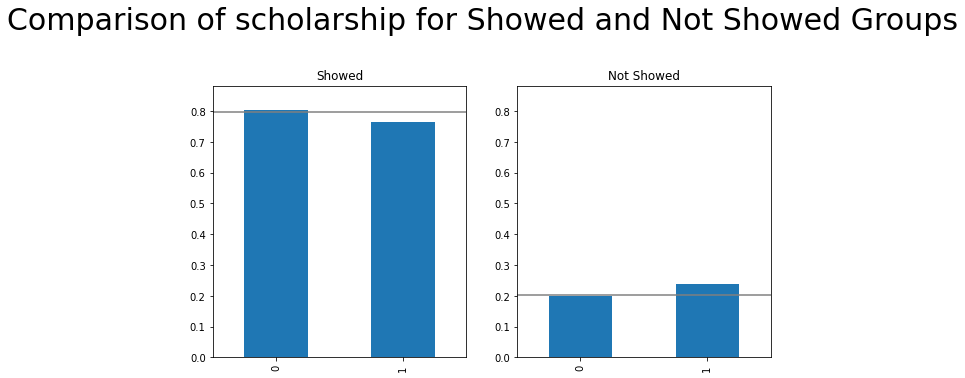

In [315]:
class_plot(df_showed, df_not_showed, 'Showed', 'Not Showed', 'scholarship')
plt.subplot(1, 2, 1)
plt.axhline(1-no_show_proportion, color = 'gray');
plt.subplot(1, 2, 2)
plt.axhline(no_show_proportion, color = 'gray');

> People that are enrolled to a benefit have a higher no show rate

##### Lastly, let's check the Neighbourhood

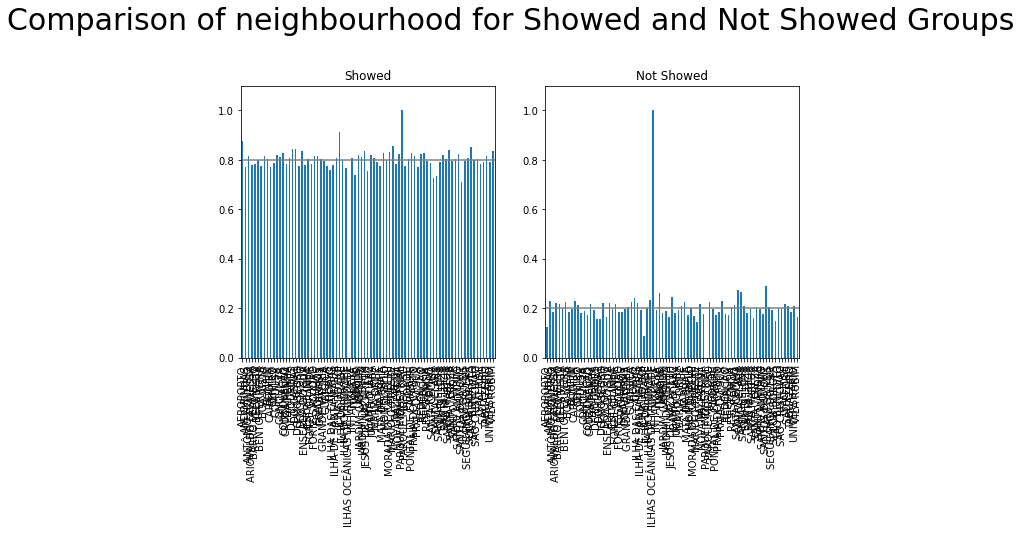

In [316]:
class_plot(df_showed, df_not_showed, 'Showed', 'Not Showed', 'neighbourhood')
plt.subplot(1, 2, 1)
plt.axhline(1-no_show_proportion, color = 'gray');
plt.subplot(1, 2, 2)
plt.axhline(no_show_proportion, color = 'gray');

> Despite the quality of the chart, it is noticeable that there are a couple of hospitals that are above the noshow rate, one in special. Let's extract those hospitals which rate is above the no show rate in 10%

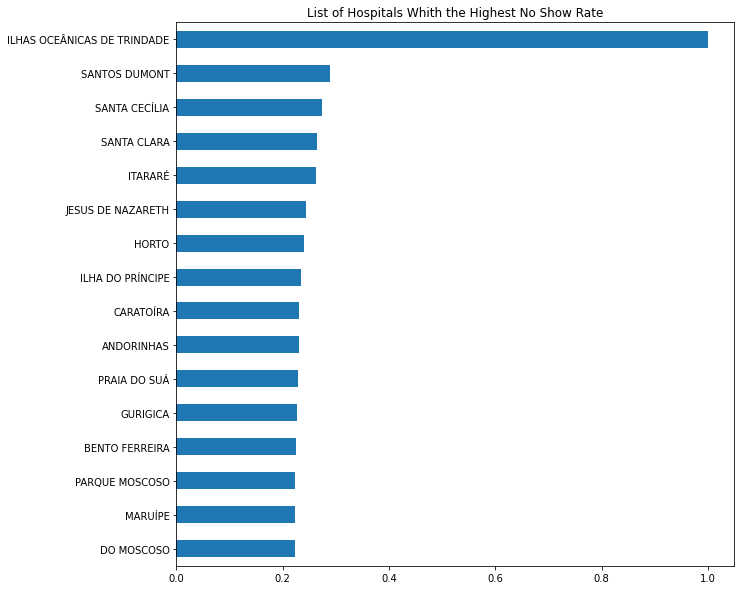

In [317]:
nh_ns = df_not_showed.neighbourhood.value_counts()
nh_t = df_noshow_clnd.neighbourhood.value_counts()
nh_prop = np.true_divide(nh_ns, nh_t)
ns_hospitals = nh_prop[nh_prop>no_show_proportion*1.1]
ns_hospitals = ns_hospitals.sort_values(ascending = True)
ns_hospitals.plot(kind = 'barh', figsize = (10,10));
plt.title("List of Hospitals Whith the Highest No Show Rate");

<a id='conclusions'></a>
# Conclusions

> Among all the features we have analyzed, the age group, the appointment day and the neighborhood are the most relevant features to consider in a no show prediction.

> Regarding the neighbourhood, it is quite evident that there is a strong reason why people are not showing there.
Without knowing the distance to the patient's house or other factors such as availability of mass transportation system or whether this is a handicap friendly zone, it is not possible to conclude what is the influence, but definetively is a strong feature to consider.

> Along the analisis, it was evident that the sms communication must be reviewed, because there is a considerable amount of patients that did not show up in the group that received the sms.

> Some other features could enrich the analysis, such as the type of visit, if has kids, married, employed, etc.